## Credit Card Fraud Detection

Key Highlights:

1.Using various sampling techniques to deal with imbalance dataset: Undersample, oversample, smote algorithm

2.Using various machine learning algorithm to train dataset after sampling: Logistics Regression, SVM, Random Forest, XGBoost, Ensemble learning. 

3.Different sampling techniques do not yield significant result differences, hence not all combinations of sampling techniques+ML algorithms are shown

4.Achieved AUC>96% (Random Forest), Recall score>92%

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import *
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split,GridSearchCV,StratifiedKFold
from sklearn.metrics import accuracy_score,log_loss,roc_auc_score,f1_score,precision_score,recall_score,confusion_matrix,roc_curve,auc,precision_recall_curve
from sklearn.pipeliyne import Pipeline
from sklearn.ensemble import GradientBoostingClassifier
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn.svm import SVC
from imblearn.over_sampling import SMOTE
from scipy import stats

In [4]:
df=pd.DataFrame(pd.read_csv('creditcard.csv'))
data=pd.DataFrame(pd.read_csv('creditcard.csv'))
dfnormal=df[df['Class']==0]
dffraud=df[df['Class']==1]

In [15]:
#Plot the two-class distribution; show 4 subplots at one time
def plothist(df,classes,col_names):
    dfnormal = df[df[classes] == 0]
    dffraud = df[df[classes] == 1]
    fig,ax=plt.subplots(nrows=2,ncols=2,figsize=(10,10))
    sns.distplot(dfnormal[col_names[0]],hist=False,kde=True,color='g',norm_hist=True,label='Normal',ax=ax[0,0],axlabel=col_names[0])
    sns.distplot(dffraud[col_names[0]], hist=False, kde=True, color='m', norm_hist=True, label='Fraud', ax=ax[0, 0],axlabel=col_names[0])
    sns.distplot(dfnormal[col_names[1]],hist=False,kde=True,color='g',norm_hist=True,label='Normal',ax=ax[0,1],axlabel=col_names[1])
    sns.distplot(dffraud[col_names[1]], hist=False, kde=True, color='m', norm_hist=True, label='Fraud', ax=ax[0, 1],axlabel=col_names[1])
    sns.distplot(dfnormal[col_names[2]],hist=False,kde=True,color='g',norm_hist=True,label='Normal',ax=ax[1,0],axlabel=col_names[2])
    sns.distplot(dffraud[col_names[2]], hist=False, kde=True, color='m', norm_hist=True, label='Fraud', ax=ax[1, 0],axlabel=col_names[2])
    sns.distplot(dfnormal[col_names[3]],hist=False,kde=True,color='g',norm_hist=True,label='Normal',ax=ax[1,1],axlabel=col_names[3])
    sns.distplot(dffraud[col_names[3]], hist=False, kde=True, color='m', norm_hist=True, label='Fraud', ax=ax[1,1],axlabel=col_names[3])


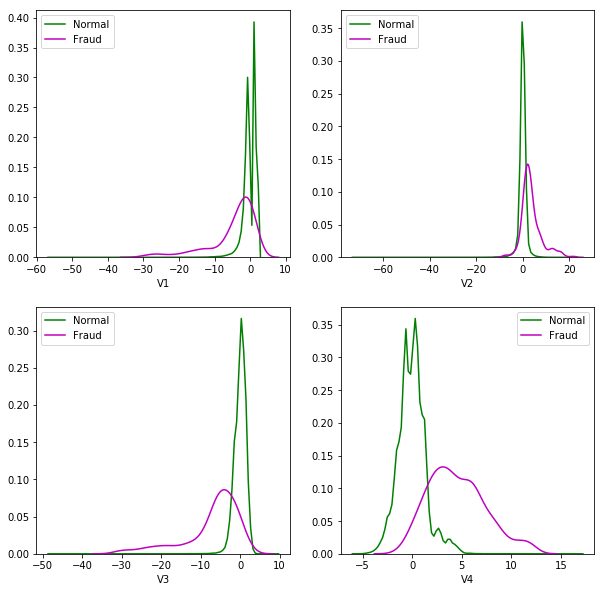

In [16]:
plothist(df,'Class',df.columns[1:5]) #Show the first four variables as illustration

In [5]:
#Visualize differences in transaction timing patterns between the two groups 
timecopy=np.array(df['Time'])
timecopy=timecopy/3600
timecopy=timecopy.astype('int')
hour=np.mod(timecopy,24)
df['hour']=hour
plt.hist((df['hour'][df['Class']==0],df['hour'][df['Class']==1]),bins=24,color=['blue','red'],normed=True) #Histogram of two groups together (transaction time distribution)
plt.legend(['Normal','Fraud'])
plt.title('Transaction distribution over time')
plt.xlabel('Hour')

In [6]:
#Since the dataset is highly imbalanced, below are two functions to undersample normal cases and oversample fraud cases
def undersample(df,times):
    #Undersample data (Class=0) s.t. sample size(Class=0):sample_size(Class=1)=times
    #Return undersampled dataframe df_under, together with X and y
    normal_amount = len(df[df.Class == 0])
    fraud_amount = len(df[df.Class == 1])
    fraud_index = df[df['Class'] == 1].index
    normal_index = df[df['Class'] == 0].index
    undersample_normal_index = np.random.choice(normal_index, int(fraud_amount * times), replace=False)
    undersample_index = np.concatenate((undersample_normal_index, fraud_index))
    df_under = df.iloc[undersample_index, :]
    X = df_under.drop('Class',axis=1)
    y = df_under['Class']
    df_under.index=np.arange(df_under.shape[0])
    X.index = np.arange(X.shape[0])
    y.index = np.arange(y.shape[0])
    return df_under,X,y

def oversample(df,n):
    #Oversample fraud data (Class=1) n times and append to the original dataframe
    dfos=df.copy()
    dffraud = df[df['Class'] == 1]
    for iteration in range(n):
        dfos=dfos.append(dffraud,ignore_index=True)
    dfos.index=np.arange(dfos.shape[0])
    X=dfos.drop(['Class'],axis=1)
    y=dfos['Class']
    return dfos,X,y


In [7]:
 #First, undersample normal class s.t. sample size(Normal):sample_size(Fraud)=n0, then use smote algorithm to interpolate
def under_smote_sample(df,n0):
    df_under,X,y=undersample(df,n0)
    os = SMOTE(random_state=0,kind='borderline2')
    X_smote,y_smote=os.fit_sample(X,y)   #Note that X_smote, y_smote are ndarray, not dataframes
    array_smote = np.hstack((X_smote, y_smote.reshape(len(y_smote), 1)))
    df_smote=pd.DataFrame(data=array_smote,columns=np.concatenate((np.array(X.columns),['Class'])))
    X_smote,y_smote=df_smote.drop(['Class'],axis=1),df_smote['Class']
    return df_smote,X_smote,y_smote


In [8]:
def rocauc(clf,X_train,X_test,y_train,y_test):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr,tpr,color='b',label='AUC = %.2f'%(roc_auc))
    plt.plot([0,1],[0,1],linestyle='--',color='r',label='Random Guessing')
    plt.legend(loc='lower right')
    plt.xlim(-0.1,1.1)
    plt.ylim(-0.1, 1.1)
    plt.xticks(np.arange(0,1.2,0.2))
    plt.yticks(np.arange(0, 1.2, 0.2))
    plt.xlabel('fpr')
    plt.ylabel('tpr')
    plt.title('Receiver Operator Characteristic')
    plt.grid()
    plt.show()

def confusion(clf,X_train,X_test,y_train,y_test):
    clf.fit(X_train,y_train)
    y_pred=clf.predict(X_test)
    confmat=confusion_matrix(y_test,y_pred)
    fig,ax = plt.subplots(figsize=(5, 5))
    ax.matshow(confmat,cmap=plt.cm.Blues,alpha=0.3)
    for i in range(confmat.shape[0]):
        for j in range(confmat.shape[1]):
            ax.text(x=j,y=i,s=confmat[i,j],va='center',ha='center')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()



In [9]:
#Create copy df1 with smaller sample size to compute feature importance matrix via random forest
df1=df.copy()
sc=StandardScaler()
df1['Amountnormed']=sc.fit_transform(df1['Amount'].values.reshape(-1,1))
df1=df1.drop(['Time','Amount'],axis=1)
df_under1,X1,y1=undersample(df1,2)
X_train,X_test,y_train,y_test=train_test_split(X1,y1,stratify=y1,test_size=0.2,random_state=1)

In [32]:
#Using random forest to print feature importance matrix
forest = RandomForestClassifier(n_estimators=300, n_jobs=1, random_state=0)
Xcolnames = X_train.columns.values
forest.fit(X_train,y_train)
importances = forest.feature_importances_
indices = np.argsort(importances)[::-1]
importance_matrix = []
for f in range(X1.shape[1]):
    importance_matrix.append([Xcolnames[indices[f]], importances[indices[f]]])
importance_matrix = np.array(importance_matrix)

print(importance_matrix)

[['V14' '0.1551782533231818']
 ['V10' '0.1476958539396102']
 ['V17' '0.11953188968680438']
 ['V12' '0.10332952136467992']
 ['V11' '0.08864259117656267']
 ['V4' '0.07099608557571455']
 ['V16' '0.04665400179732677']
 ['V3' '0.04312126301813925']
 ['V7' '0.03680669518584909']
 ['V2' '0.0204671514439077']
 ['V9' '0.014357826843700525']
 ['Amountnormed' '0.013285683145010243']
 ['V6' '0.012791535373740056']
 ['V21' '0.01139602523109849']
 ['V8' '0.010236821577548754']
 ['V19' '0.009640253998117587']
 ['V18' '0.009634969925285439']
 ['V27' '0.009600348645131875']
 ['V13' '0.007743319559726702']
 ['V22' '0.007739101463525846']
 ['V26' '0.007644583323628039']
 ['V1' '0.007616891904545425']
 ['V20' '0.007475905845015299']
 ['V5' '0.007369358503700603']
 ['V23' '0.006565288043671852']
 ['V15' '0.006450827398757775']
 ['V24' '0.005231869441073527']
 ['V28' '0.004845014691532397']
 ['V25' '0.0042245508213083005']
 ['hour' '0.0037265177521049104']]


In [16]:
#Normalize 'amount' variable, split dataset to training and testing sets:
sc=StandardScaler()
df['Amountnormed']=sc.fit_transform(df['Amount'].values.reshape(-1,1))
df=df.drop(['Time','Amount'],axis=1)

dfc1=df.copy() #Make a copy before dropping unimportant variables
df=df.drop(['hour','V25','V28','V24','V15','V23','V5','V20','V1','V26','V22'],axis=1)


X=df.drop(['Class'],axis=1)
y=df['Class']
X_train,X_test,y_train,y_test=train_test_split(X,y,stratify=y,test_size=0.2,random_state=1)

df_train=df.iloc[X_train.index,:]
df_train.index=np.arange(df_train.shape[0])


##1. Grid Search for Logistics Regression using undersample technique:

In [44]:
lr_scores=[['Ratio','AUC_score']]
pipe_lr=Pipeline([('lr',LogisticRegression(penalty='l2'))])
param_range=[0.00001,0.00005,0.0001,0.0005,0.001,0.005,0.01,0.05,0.1,0.5,1,5,10,50,100,200,500,1000]
param_grid=[{'lr__C':param_range}]
for i in [0.5,0.8,1,2,3,4,5,6,7,8]:
    df_under, X1, y1 = undersample(df_train, i)
    gs = GridSearchCV(estimator=pipe_lr, param_grid=param_grid, scoring='roc_auc', cv=10)
    gs = gs.fit(X1, y1)
    print('If normal:fraud = %f, optimal value of C = %f, AUC score is %f on training set' %(i,gs.best_params_['lr__C'],gs.best_score_))
    #Use the best parameter to train and test on the overall dataset:
    lreg=LogisticRegression(penalty='l2',C=gs.best_params_['lr__C'],random_state=0)
    lreg.fit(X1,y1)
    y_pred_lr=lreg.predict(X_test)
    lr_scores.append([i,roc_auc_score(y_test,y_pred_lr)])
lr_scores=np.array(lr_scores)    
print(lr_scores)


If normal:fraud = 0.500000, optimal value of C = 0.000500, AUC score is 0.976385 on training set
If normal:fraud = 0.800000, optimal value of C = 0.010000, AUC score is 0.979312 on training set
If normal:fraud = 1.000000, optimal value of C = 0.001000, AUC score is 0.976747 on training set
If normal:fraud = 2.000000, optimal value of C = 0.100000, AUC score is 0.980361 on training set
If normal:fraud = 3.000000, optimal value of C = 0.100000, AUC score is 0.976647 on training set
If normal:fraud = 4.000000, optimal value of C = 0.050000, AUC score is 0.978714 on training set
If normal:fraud = 5.000000, optimal value of C = 0.010000, AUC score is 0.977388 on training set
If normal:fraud = 6.000000, optimal value of C = 0.050000, AUC score is 0.978745 on training set
If normal:fraud = 7.000000, optimal value of C = 0.100000, AUC score is 0.977809 on training set
If normal:fraud = 8.000000, optimal value of C = 0.010000, AUC score is 0.978219 on training set
[['Ratio' 'AUC_score']
 ['0.5'

Hence, when using logistics regression, optimal ratio normal:fraud=7, AUC score=0.953

##2. Grid Search for SVM using undersample techniques

In [61]:
svm_scores=[['Ratio','AUC_score']]
pipe_svm=Pipeline([('svm',SVC(kernel='rbf'))])
param_C=[0.001,0.01,0.05,0.1,1,10]
param_gamma=[0.001,0.01,0.05,0.1,1,10]
param_grid=[{'svm__C':param_C,'svm__gamma':param_gamma}]
for i in [0.5,0.8,1,2,3,4,5]:
    df_under, X1, y1 = undersample(df_train, i)
    gs = GridSearchCV(estimator=pipe_svm, param_grid=param_grid, scoring='roc_auc', cv=10)
    gs = gs.fit(X1, y1)
    print('If normal:fraud = %f, optimal value of C = %f, optimal value of gamma = %f, AUC score is %f on training set' %(i,gs.best_params_['svm__C'],gs.best_params_['svm__gamma'],gs.best_score_))
    #Use the best parameter to train and test on the overall dataset:
    svm=SVC(C=gs.best_params_['svm__C'],kernel='rbf',gamma=gs.best_params_['svm__gamma'],random_state=0)
    svm.fit(X1,y1)
    y_pred_svm=svm.predict(X_test)
    svm_scores.append([i,roc_auc_score(y_test,y_pred_svm)])
svm_scores=np.array(svm_scores)    
print(svm_scores)

If normal:fraud = 0.500000, optimal value of C = 1.000000, optimal value of gamma = 0.010000, AUC score is 0.981091 on training set
If normal:fraud = 0.800000, optimal value of C = 1.000000, optimal value of gamma = 0.001000, AUC score is 0.981416 on training set
If normal:fraud = 1.000000, optimal value of C = 10.000000, optimal value of gamma = 0.010000, AUC score is 0.983563 on training set
If normal:fraud = 2.000000, optimal value of C = 10.000000, optimal value of gamma = 0.010000, AUC score is 0.979685 on training set
If normal:fraud = 3.000000, optimal value of C = 10.000000, optimal value of gamma = 0.010000, AUC score is 0.981962 on training set
If normal:fraud = 4.000000, optimal value of C = 10.000000, optimal value of gamma = 0.001000, AUC score is 0.978367 on training set
If normal:fraud = 5.000000, optimal value of C = 10.000000, optimal value of gamma = 0.010000, AUC score is 0.980579 on training set
[['Ratio' 'AUC_score']
 ['0.5' '0.9450050173417708']
 ['0.8' '0.9452271

In [ ]:
Hence, when using SVM, optimal ratio normal:fraud=2, AUC score=0.962

##3. Grid Search for Random Forest using undersample techniques

In [18]:
rf_scores=[['Ratio','AUC_score']]
pipe_rf=Pipeline([('rf',RandomForestClassifier(criterion='entropy',random_state=0))])
param_n=[100,150,200,250,300]
param_depth=[6,7,8,9]
param_grid=[{'rf__n_estimators':param_n,'rf__max_depth':param_depth}]
for i in [1,2,3,4]:
    df_under, X1, y1 = undersample(df_train, i)
    gs = GridSearchCV(estimator=pipe_rf, param_grid=param_grid, scoring='roc_auc', cv=10)
    gs = gs.fit(X1, y1)
    print('If normal:fraud = %f, optimal value of n = %f, optimal value of depth = %f, AUC score is %f on training set' %(i,gs.best_params_['rf__n_estimators'],gs.best_params_['rf__max_depth'],gs.best_score_))
    #Use the best parameter to train and test on the overall dataset:
    rf=RandomForestClassifier(n_estimators=gs.best_params_['rf__n_estimators'],max_depth=gs.best_params_['rf__max_depth'],random_state=0,criterion='entropy')
    rf.fit(X1,y1)
    y_pred_rf=rf.predict(X_test)
    rf_scores.append([i,roc_auc_score(y_test,y_pred_rf)])

rf_scores=np.array(rf_scores)    
print(rf_scores)



If normal:fraud = 1.000000, optimal value of n = 250.000000, optimal value of depth = 9.000000, AUC score is 0.981653 on training set
If normal:fraud = 2.000000, optimal value of n = 250.000000, optimal value of depth = 6.000000, AUC score is 0.981415 on training set
If normal:fraud = 3.000000, optimal value of n = 250.000000, optimal value of depth = 6.000000, AUC score is 0.979928 on training set
If normal:fraud = 4.000000, optimal value of n = 100.000000, optimal value of depth = 6.000000, AUC score is 0.983062 on training set
[['Ratio' 'AUC_score']
 ['1' '0.940628481274333']
 ['2' '0.9491048459338716']
 ['3' '0.952507701870844']
 ['4' '0.9530528622535115']]


In [ ]:
Hence, when using random forest, optimal ratio normal:fraud=4, AUC score=0.953

##4. Now let's use ensemble learning to combine 3 methods with optimal parameters. Result is no better than any single method

In [20]:
consolidated_pred=[]
consolidated_prob=[]

#LR:
df_under, X1, y1 = undersample(df_train, 7)
lreg = LogisticRegression(penalty='l2', C=0.1, random_state=0)
lreg.fit(X1, y1)
y_pred_lr = lreg.predict(X_test)
y_prob_lr_tempt=lreg.predict_proba(X_test)
y_pred_lr,y_prob_lr=list(y_pred_lr),list(y_prob_lr_tempt[:,1])
consolidated_pred.append(y_pred_lr)
consolidated_prob.append(y_prob_lr)

#SVM:
df_under, X1, y1 = undersample(df_train, 2)
svm = SVC(C=10, kernel='rbf', gamma=0.01, random_state=0,probability=True)
svm.fit(X1, y1)
y_pred_svm = svm.predict(X_test)
y_prob_svm_tempt=svm.predict_proba(X_test)
y_pred_svm,y_prob_svm=list(y_pred_svm),list(y_prob_svm_tempt[:,1])
consolidated_pred.append(y_pred_svm)
consolidated_prob.append(y_prob_svm)

#RF:
df_under, X1, y1 = undersample(df_train, 4)
rf = RandomForestClassifier(n_estimators=100,max_depth=6, random_state=0, criterion='entropy')
rf.fit(X1, y1)
y_pred_rf = rf.predict(X_test)
y_prob_rf_tempt=rf.predict_proba(X_test)
y_pred_rf,y_prob_rf=list(y_pred_rf),list(y_prob_rf_tempt[:,1])
consolidated_pred.append(y_pred_rf)
consolidated_prob.append(y_prob_rf)

consolidated_pred=np.array(consolidated_pred)
consolidated_prob=np.array(consolidated_prob)
y_pred_ensemble= stats.mode(consolidated_pred)[0]
y_pred_final=y_pred_ensemble.reshape(y_pred_ensemble.shape[1],)
y_prob_ensemble=np.mean(consolidated_prob,axis=0)
y_prob_final=y_prob_ensemble.reshape(len(y_prob_ensemble))

print('AUC score is %.3f' %roc_auc_score(y_test,y_pred_final))
print('Recall score is %.3f' %recall_score(y_test,y_pred_final))




AUC score is 0.952
Recall score is 0.908


##5. Using smote algorithm to subsample, then use XGBoost to build classifier
Since there are so many hyperparameters to tune, we tune one or two of them each step

In [29]:
df_smote,X_smote,y_smote=under_smote_sample(df_train,5)
#Grid Search for xgb (Step 1):
param_test1 = {'max_depth':range(3,8,2),'min_child_weight':range(1,6,2)}
gs1 = GridSearchCV(estimator = XGBClassifier(learning_rate =0.1, n_estimators=130,gamma=0, subsample=0.8, colsample_bytree=0.8,objective= 'binary:logistic'),\
param_grid = param_test1, scoring='roc_auc',iid=False,cv=3)
gs1=gs1.fit(X_smote,y_smote)
print(gs1.best_score_)
print(gs1.best_params_)


0.9829258021369266
{'max_depth': 7, 'min_child_weight': 3}


In [30]:
#Grid Search for xgb (Step 2):
param_test2 = {'gamma':[0,0.05,0.1,0.15,0.2,0.25,0.3]}
gs2 = GridSearchCV(estimator = XGBClassifier(learning_rate =0.1, n_estimators=130,max_depth=7,min_child_weight=3, subsample=0.8, colsample_bytree=0.8,objective= 'binary:logistic'),\
param_grid = param_test2, scoring='roc_auc',iid=False,cv=3)
gs2=gs2.fit(X_smote,y_smote)
print(gs2.best_score_)
print(gs2.best_params_)

0.9844624660818319
{'gamma': 0.2}


In [31]:
#Grid Search for xgb (Step3):
param_test3 = {'n_estimators':[20,40,60,80,100,130,150,200,250,300]}
gs3 = GridSearchCV(estimator = XGBClassifier(learning_rate =0.1, gamma=0.2,max_depth=7,min_child_weight=3, subsample=0.8, colsample_bytree=0.8,objective= 'binary:logistic'),\
param_grid = param_test3, scoring='roc_auc',iid=False,cv=3)
gs3=gs3.fit(X_smote,y_smote)
print(gs3.best_score_)
print(gs3.best_params_)

0.9852231506476562
{'n_estimators': 250}


In [32]:
#Grid Search for xgb (Step 4):
param_test4 = {'learning_rate':[0.01,0.02,0.05,0.08,0.1]}
gs4 = GridSearchCV(estimator = XGBClassifier(cv=3, n_estimators=250,gamma=0.2,max_depth=7,min_child_weight=3, subsample=0.8, colsample_bytree=0.8,objective= 'binary:logistic'),\
param_grid = param_test4, scoring='roc_auc',iid=False)
gs4=gs4.fit(X_smote,y_smote)
print(gs4.best_score_)
print(gs4.best_params_)

0.9852231506476562
{'learning_rate': 0.1}


C:\Users\User\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


AUC score is 0.946
Recall score is 0.918


C:\Users\User\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


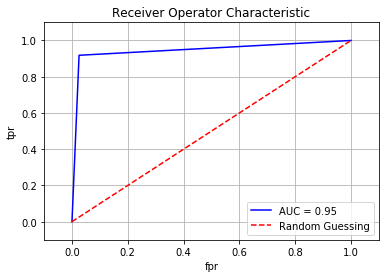

C:\Users\User\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


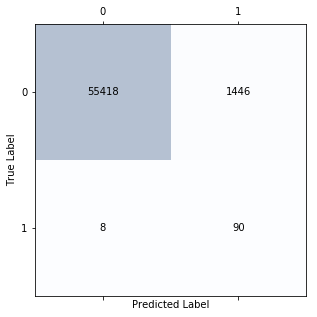

In [34]:
#Now use the best set of parameters to run XGBoost on Smote sample:
xgb=XGBClassifier(learning_rate =0.1, n_estimators=250,gamma=0.2, subsample=0.8, colsample_bytree=0.8,objective= 'binary:logistic',max_depth=7,min_child_weight=3)
xgb.fit(X_smote,y_smote)
y_pred=xgb.predict(X_test)
print('AUC score is %.3f' %roc_auc_score(y_test,y_pred))
print('Recall score is %.3f' %recall_score(y_test,y_pred))
rocauc(xgb,X_smote,X_test,y_smote,y_test)
confusion(xgb,X_smote,X_test,y_smote,y_test)